## setting up

In [65]:
%pip install pandas matplotlib seaborn xgboost scikit-learn openpyxl

# 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


## 合并数据库

In [66]:
# 读取上传的 3 个 Excel 数据文件
home_imp = pd.read_excel("Home_Improvement_data.xlsx")
home_sup = pd.read_excel("Home_Supply_data.xlsx")
kitchen = pd.read_excel("Kitchenware_data.xlsx")

# 添加标签
home_imp["Category"] = "Home Improvement"
home_sup["Category"] = "Home Supplies"
kitchen["Category"] = "Kitchenware"

# 合并数据
df = pd.concat([home_imp, home_sup, kitchen], ignore_index=True)

In [67]:
df.describe()

,Shop Total Units Sold,7-day Units Sold,7-day Revenue,Total Units Sold,Total Revenue,No.of related Creators,No.of Related lives,No.of related videos
count,9.000000e+03,9000.000000,9000.000000,9.000000e+03,9.000000e+03,9000.000000,9000.000000,9000.000000
mean,7.397644e+04,101.208000,1637.615478,3.853591e+03,5.980435e+04,231.811667,155.934444,184.881778
std,2.511346e+05,437.337476,9167.609457,1.928037e+04,3.254082e+05,992.808028,1007.919704,789.916857
min,0.000000e+00,6.000000,4.830000,7.000000e+00,2.600000e+01,0.000000,0.000000,0.000000
25%,2.137000e+03,12.000000,138.647500,1.360000e+02,1.574750e+03,2.000000,0.000000,2.000000
50%,1.029150e+04,27.000000,349.860000,5.125000e+02,6.036000e+03,12.000000,1.000000,15.000000
75%,4.343700e+04,66.000000,957.732500,2.089250e+03,2.580075e+04,85.000000,28.000000,87.250000
max,3.637209e+06,15922.000000,465479.400000,1.034834e+06,1.155619e+07,25036.000000,27839.000000,22273.000000


## 数据清洗

### 对价格和 commission rate 进行清洗，string -> number, 价格区间用中值取代


In [68]:
# cleanning price 区间用中值代替
def clean_price(p):
    if isinstance(p, str):
        p = p.replace('$', '').replace(',', '').strip()
        if '-' in p:
            parts = p.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        return float(p)
    return p

df["Price"] = df["Price"].apply(clean_price)

# cleanning commission rate 缺失值用 median 代替
def clean_commission(r):
    if isinstance(r, str):
        r = r.replace('%', '').strip()
        if r == '-' or r == '':
            return 10
        return float(r)
    return r

df["Commission Rate"] = df["Commission Rate"].apply(clean_commission)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product Image            9000 non-null   object 
 1   Product Name             9000 non-null   object 
 2   Price                    9000 non-null   float64
 3   Region                   9000 non-null   object 
 4   Shops                    8995 non-null   object 
 5   Shop Total Units Sold    9000 non-null   int64  
 6   Products Category        9000 non-null   object 
 7   Commission Rate          9000 non-null   float64
 8   7-day Units Sold         9000 non-null   int64  
 9   7-day Revenue            9000 non-null   float64
 10  Total Units Sold         9000 non-null   int64  
 11  Total Revenue            9000 non-null   float64
 12  No.of related Creators   9000 non-null   int64  
 13  No.of Related lives      9000 non-null   int64  
 14  No.of related videos    

## 此模型意义为测算不同因子对 total unit sold 的影响
### 因为测算整体影响，所以忽略7日数据
### 忽略 total revenue (perfectly correlated)
### 测算因子为：price, commission rate, No.of related Creators, No.of related Lives, No.of related Videos

In [70]:
# 只保留关心的因子和结果
df_clean = df[[
    "Total Units Sold",
    "Price",
    "Commission Rate",
    "No.of related Creators",
    "No.of Related lives",
    "No.of related videos",
    "Category"
]]

In [76]:
df_clean.describe()

,Total Units Sold,Price,Commission Rate,No.of related Creators,No.of Related lives,No.of related videos
count,9.000000e+03,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,3.853591e+03,22.362066,11.332691,231.811667,155.934444,184.881778
std,1.928037e+04,44.030104,3.983572,992.808028,1007.919704,789.916857
min,7.000000e+00,0.520000,1.000000,0.000000,0.000000,0.000000
25%,1.360000e+02,6.990000,10.000000,2.000000,0.000000,2.000000
50%,5.125000e+02,12.990000,10.000000,12.000000,1.000000,15.000000
75%,2.089250e+03,24.370000,12.000000,85.000000,28.000000,87.250000
max,1.034834e+06,1469.990000,70.000000,25036.000000,27839.000000,22273.000000


## 存在极端值，例如销量在百万以上的产品，且数据特性高度右偏，所以采用 log-log 去偏

In [74]:
def trim_total_units(df, category_name, quantile=0.995):
    subset = df[df["Category"] == category_name].copy()
    print(f"{category_name} initial size:", subset.shape)

    subset["Total Units Sold"] = pd.to_numeric(subset["Total Units Sold"], errors="coerce")
    subset = subset.dropna(subset=["Total Units Sold"])

    threshold = subset["Total Units Sold"].quantile(quantile)

    trimmed = subset[subset["Total Units Sold"] <= threshold]

    return trimmed.drop(columns="Category")

In [75]:
# 应用函数
df_home_trimmed = trim_total_units(df_clean, "Home Improvement")
df_supply_trimmed = trim_total_units(df_clean, "Home Supplies")
df_kitchen_trimmed = trim_total_units(df_clean, "Kitchenware")

# 打包字典
datasets_trimmed = {
    "Home Improvement": df_home_trimmed,
    "Home Supplies": df_supply_trimmed,
    "Kitchenware": df_kitchen_trimmed
}

# 查看每组剩余样本数
{key: df.shape for key, df in datasets_trimmed.items()}

Home Improvement initial size: (3000, 7)
Home Supplies initial size: (3000, 7)
Kitchenware initial size: (3000, 7)


{'Home Improvement': (2985, 6),
 'Home Supplies': (2985, 6),
 'Kitchenware': (2985, 6)}

## log-log 建模

In [79]:


# 定义 log-log 回归函数
def run_loglog_regression(df, category_name):
    # 所有变量取 log(x + 1)，避免 log(0)
    df_logged = np.log1p(df)

    # 设置 X 和 y
    X = df_logged.drop(columns="Total Units Sold")
    y = df_logged["Total Units Sold"]
    
    # 添加常数项
    X = sm.add_constant(X)
    
    # 拟合 OLS 模型
    model = sm.OLS(y, X).fit()
    
    # 输出结果
    summary = model.summary()
    coef = model.params
    ci = model.conf_int()
    ci.columns = ["2.5%", "97.5%"]
    
    return {
        "category": category_name,
        "summary": summary,
        "coef": coef,
        "conf_int": ci
    }

# 对三个产品类别分别建模
loglog_results = {
    name: run_loglog_regression(df, name)
    for name, df in datasets_trimmed.items()
}

# 生成汇总表格（系数 + 置信区间）
coef_tables = {}
for key in loglog_results:
    coef_df = pd.concat([
        loglog_results[key]["coef"],
        loglog_results[key]["conf_int"]
    ], axis=1)
    coef_df.columns = ["Coefficient", "2.5%", "97.5%"]
    coef_tables[key] = coef_df

# 展示合并结果（可视化可选）
summary_table = pd.concat(coef_tables, axis=0)
summary_table

Coefficient      2.5%     97.5%
Home Improvement const                      7.050067  6.645089  7.455045
                 Price                     -0.636714 -0.680068 -0.593360
                 Commission Rate           -0.491562 -0.641688 -0.341436
                 No.of related Creators     0.428181  0.364806  0.491556
                 No.of Related lives        0.174723  0.142830  0.206616
                 No.of related videos       0.168642  0.114194  0.223090
Home Supplies    const                      7.558568  7.235366  7.881769
                 Price                     -0.656293 -0.700126 -0.612459
                 Commission Rate           -0.363575 -0.487596 -0.239555
                 No.of related Creators     0.349378  0.296891  0.401864
                 No.of Related lives        0.197897  0.171367  0.224427
                 No.of related videos       0.157097  0.110381  0.203814
Kitchenware      const                      7.703138  7.322030  8.084246
                 Price                     -0.853050 -0.903336 -0.802763
                 Commission Rate           -0.579664 -0.722324 -0.437004
                 No.of related Creators     0.371627  0.311879  0.431376
                 No.of Related lives        0.122398  0.090029  0.154768
                 No.of related videos       0.287964  0.236008  0.339919

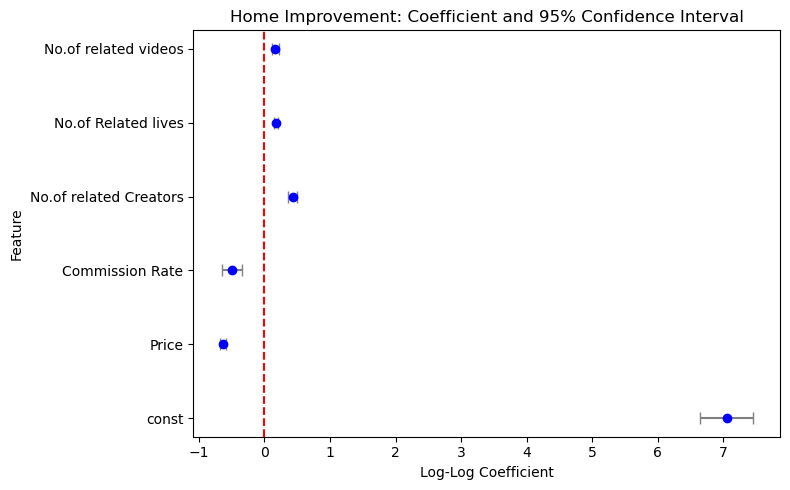

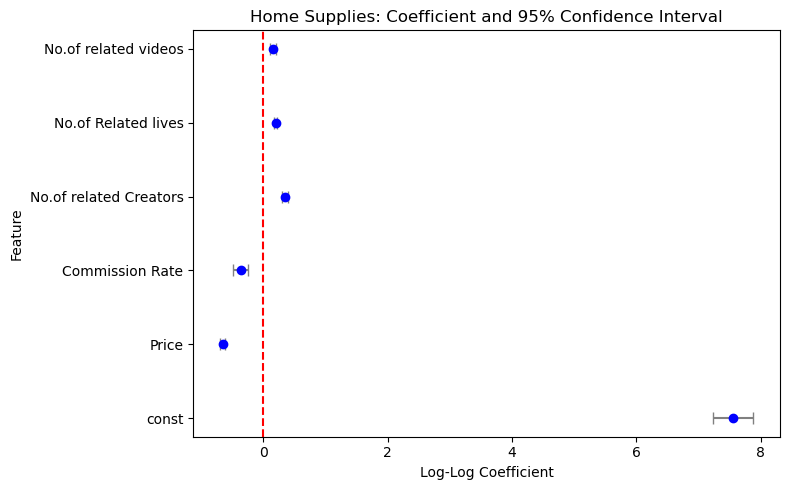

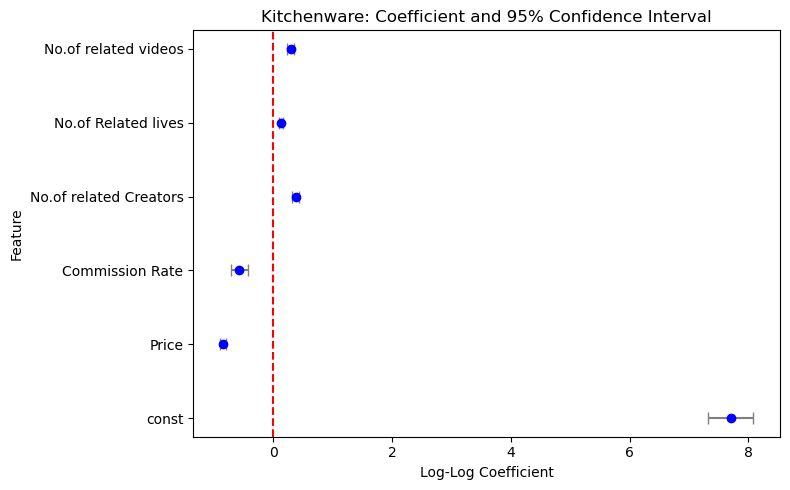

In [80]:
# 确保 summary_table 有 multi-index：(类别, 特征)
summary_df = summary_table.reset_index().rename(columns={"level_0": "Category", "level_1": "Feature"})

# 画图函数
def plot_coefficients(df, category):
    data = df[df["Category"] == category]
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        data["Coefficient"],
        data["Feature"],
        xerr=[data["Coefficient"] - data["2.5%"], data["97.5%"] - data["Coefficient"]],
        fmt='o', color='blue', ecolor='gray', capsize=4
    )
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"{category}: Coefficient and 95% Confidence Interval")
    plt.xlabel("Log-Log Coefficient")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# 示例：绘制所有类别的图
for cat in summary_df["Category"].unique():
    plot_coefficients(summary_df, cat)

## 因子之间的相关性

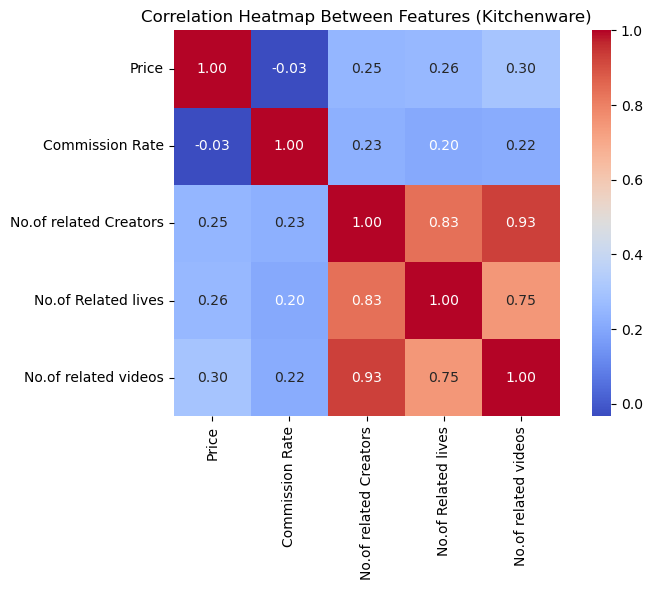

In [81]:
category = "Kitchenware"
df_log = np.log1p(datasets_trimmed[category]) 

# 只关注五个因子之间的相关性
features = ["Price", "Commission Rate", "No.of related Creators", "No.of Related lives", "No.of related videos"]
corr_matrix = df_log[features].corr()

# 热力图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title(f"Correlation Heatmap Between Features ({category})")
plt.tight_layout()
plt.show()

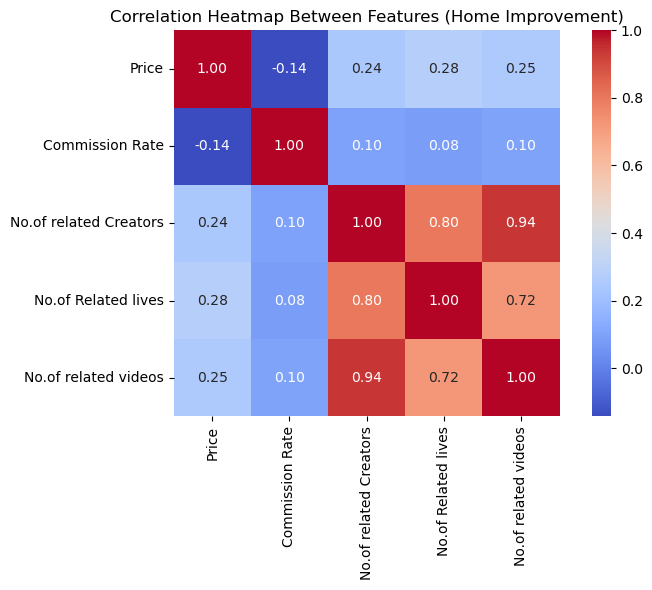

In [83]:
category = "Home Improvement"
df_log = np.log1p(datasets_trimmed[category])

# 只关注五个因子之间的相关性（不包含目标变量）
features = ["Price", "Commission Rate", "No.of related Creators", "No.of Related lives", "No.of related videos"]
corr_matrix = df_log[features].corr()

# 画热力图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title(f"Correlation Heatmap Between Features ({category})")
plt.tight_layout()
plt.show()

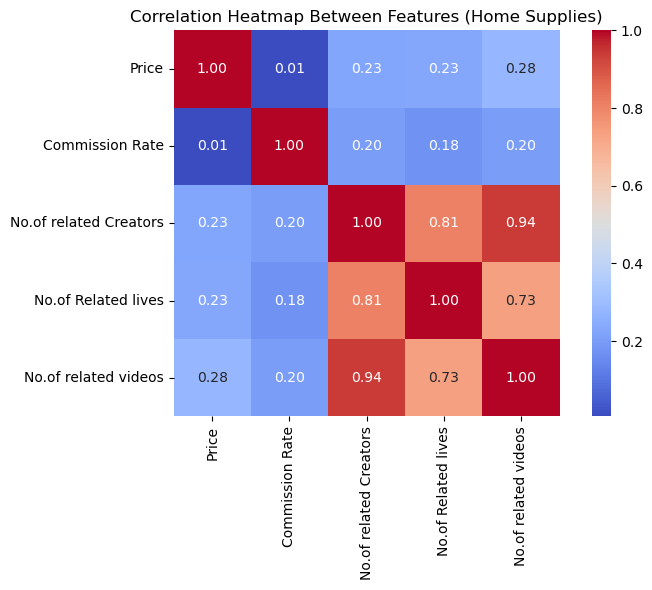

In [84]:
category = "Home Supplies"
df_log = np.log1p(datasets_trimmed[category]) 

# 只关注五个因子之间的相关性
features = ["Price", "Commission Rate", "No.of related Creators", "No.of Related lives", "No.of related videos"]
corr_matrix = df_log[features].corr()

# 画热力图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title(f"Correlation Heatmap Between Features ({category})")
plt.tight_layout()
plt.show()

根据本次 log-log 回归模型的结果，针对三类产品（Home Improvement、Home Supplies 和 Kitchenware），在这几个因子中，销量对于价格因素的影响最为显著，而内容相关的因子（如创作者数、直播数和视频数）为第二显著特征，普遍对销量有正向促进作用。尤其在 Kitchenware 类别中弹性系数高达 -0.85，表明该类产品对价格极为敏感。相比之下，内容类因子中，“相关创作者数”是最稳定且显著的正向变量，在所有品类中均对销量有强正向贡献，说明内容生态对转化效果至关重要。此外，“相关短视频数”在 Kitchenware 中的作用明显大于其他两类，而直播的边际作用则相对较弱。

## 常规线性分割测试 （显著效果差 对数去偏效果显著）

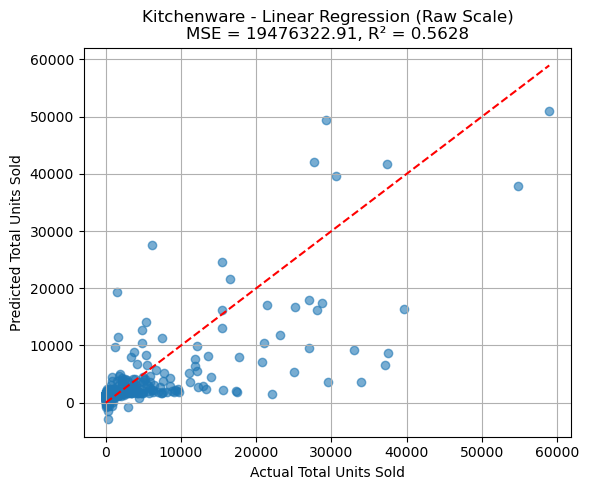

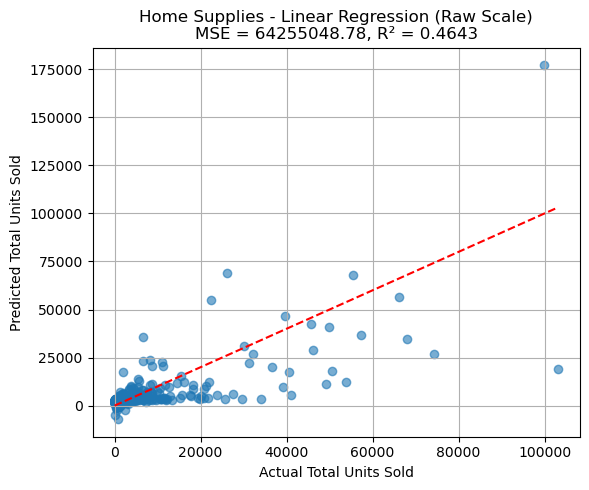

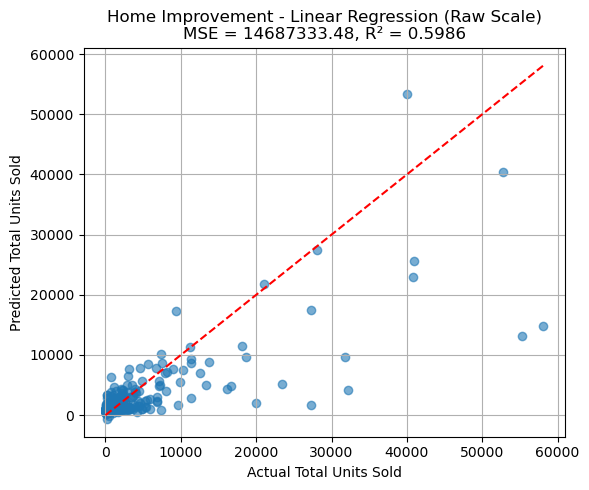

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

categories = ["Kitchenware", "Home Supplies", "Home Improvement"]

results_linear = {}

for cat in categories:
    df = datasets_trimmed[cat]  # 注意：未 log1p 转换
    df = df.dropna()  # 保险起见再做一次空值清洗

    # 拆分特征和目标
    X = df.drop(columns="Total Units Sold")
    y = df["Total Units Sold"]

    # 划分训练测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 模型训练
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 模型预测 & 评估
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 保存结果
    results_linear[cat] = {"mse": mse, "r2": r2, "y_test": y_test, "y_pred": y_pred}

    # 可视化
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Total Units Sold")
    plt.ylabel("Predicted Total Units Sold")
    plt.title(f"{cat} - Linear Regression (Raw Scale)\nMSE = {mse:.2f}, R² = {r2:.4f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## log log 下分割训练测试

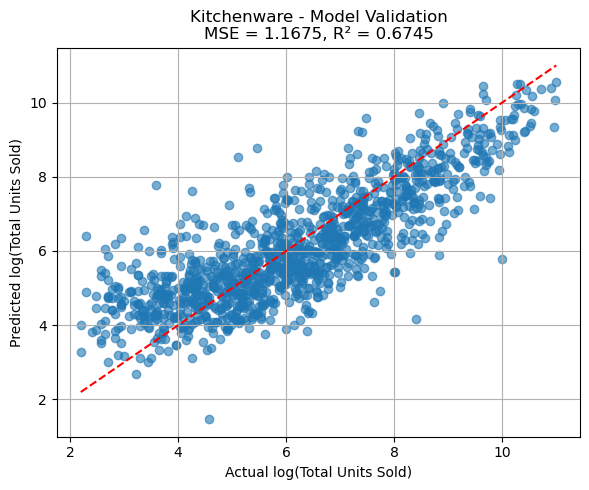

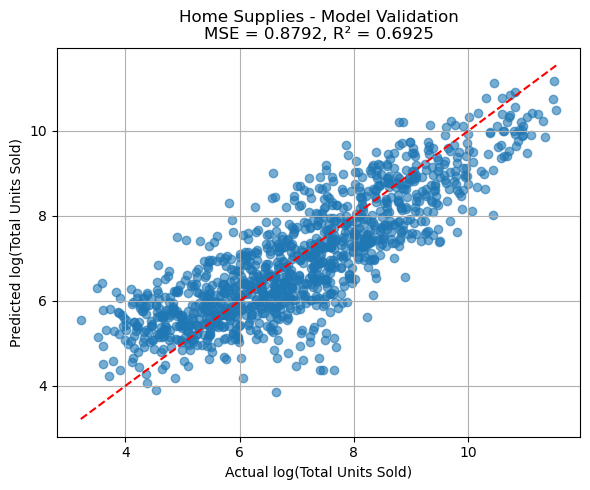

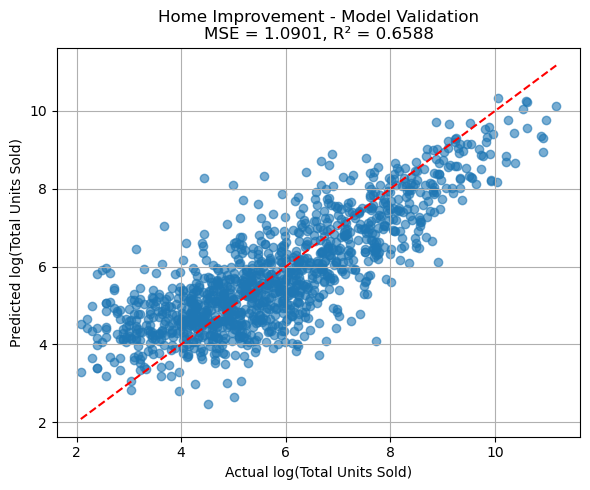

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ⚙️ log(x+1) 后建模的 datasets（前提是 datasets_trimmed 已 log 处理 + 剔除极端值）
categories = ["Kitchenware", "Home Supplies", "Home Improvement"]

results = {}

for cat in categories:
    df = datasets_trimmed[cat]
    df_log = np.log1p(df)

    # 拆分特征和目标
    X = df_log.drop(columns="Total Units Sold")
    y = df_log["Total Units Sold"]

    # 划分训练/测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    # 训练模型
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 预测 & 评估
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 保存结果
    results[cat] = {"mse": mse, "r2": r2, "y_test": y_test, "y_pred": y_pred}

    # 可视化
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual log(Total Units Sold)")
    plt.ylabel("Predicted log(Total Units Sold)")
    plt.title(f"{cat} - Model Validation\nMSE = {mse:.4f}, R² = {r2:.4f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

对于三个类目，模型的测验结果说明，被测试因子的变动可以解释70%左右总销量的变化。整体模型预测有效，不同因子对数据显著解释性。